### Importing Relevant Libraries, Modules & Datasets

In [1]:
from nlp_module.Processor import *
from nlp_module.Modelling import *


train = pd.read_excel('x0pa_ds_interview_round_2_train.xlsx')
test = pd.read_excel('x0pa_ds_interview_round_2_test.xlsx')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anirban\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anirban\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anirban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Text Processing Pipeline

In [2]:
# pipeline object for Tfidf Vectorisor that calls the StemmerTokeniser class, breaks down into bigrams features 
# that are ultimately normalised
pipe = Pipeline([('tfidf',TfidfVectorizer(analyzer='word', tokenizer=StemmerTokenizer(),ngram_range=(1,3), max_df=0.6)), ('norm', Normalizer())])
z_train_tfidf = pipe.fit_transform(train['Job Title'])
z_test_tfidf = pipe.transform(test['Job Title'])

In [3]:
with open('pipe.pkl', 'wb') as file: 
    pickle.dump(pipe, file)

In [4]:
print(z_train_tfidf.shape)
print(z_test_tfidf.shape)

(50000, 187249)
(20000, 187249)


### Creating Dictionary of Class Weights To Sensitize Model To Categories Less Common 

<AxesSubplot:>

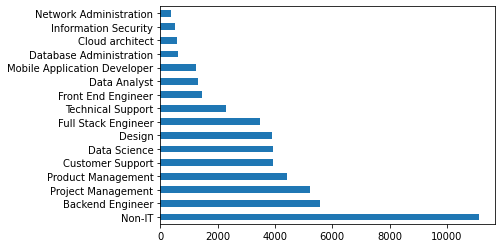

In [5]:
train['Type'].value_counts().plot(kind='barh')

In [6]:
#Rank job categories by occurences of count
job_rankings = train.groupby('Type')['id'].count().rank(ascending=False).reset_index().rename(columns= {'id':'ranking','Type':'role'})
job_rankings

,role,ranking
0,Backend Engineer,2.0
1,Cloud architect,14.0
2,Customer Support,5.0
3,Data Analyst,11.0
4,Data Science,6.0
5,Database Administration,13.0
6,Design,7.0
7,Front End Engineer,10.0
8,Full Stack Engineer,8.0
9,Information Security,15.0


In [7]:
# If classes are underrepresented indicated by ranking based on different threshold/categories, increase dictionary weights
class_weights = dict(zip(train['Type'].unique(),np.ones(len(train['Type'].unique()))))

for i in job_rankings.itertuples():
  if i[2]>10:
    class_weights[i[1]]= 5
  elif 6<=i[2]<=10:
    class_weights[i[1]]= 3
  elif 2<=i[2]<=5:
    class_weights[i[1]]= 2
  
class_weights

{'Project Management': 2,
 'Database Administration': 5,
 'Design': 3,
 'Customer Support': 2,
 'Front End Engineer': 3,
 'Full Stack Engineer': 3,
 'Data Analyst': 5,
 'Non-IT': 1.0,
 'Technical Support': 3,
 'Backend Engineer': 2,
 'Product Management': 2,
 'Data Science': 3,
 'Information Security': 5,
 'Network Administration': 5,
 'Mobile Application Developer': 5,
 'Cloud architect': 5}

### Model Training & Evaluation

In [8]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(max_iter=200, tol=1e-3,class_weight=class_weights,penalty='l2',early_stopping=True)
mod = Modelevaluator(model)
mod.fit(z_train_tfidf, train['Type'])

SGDClassifier(class_weight={'Backend Engineer': 2, 'Cloud architect': 5,
                            'Customer Support': 2, 'Data Analyst': 5,
                            'Data Science': 3, 'Database Administration': 5,
                            'Design': 3, 'Front End Engineer': 3,
                            'Full Stack Engineer': 3, 'Information Security': 5,
                            'Mobile Application Developer': 5,
                            'Network Administration': 5, 'Non-IT': 1.0,
                            'Product Management': 2, 'Project Management': 2,
                            'Technical Support': 3},
              early_stopping=True, max_iter=200)

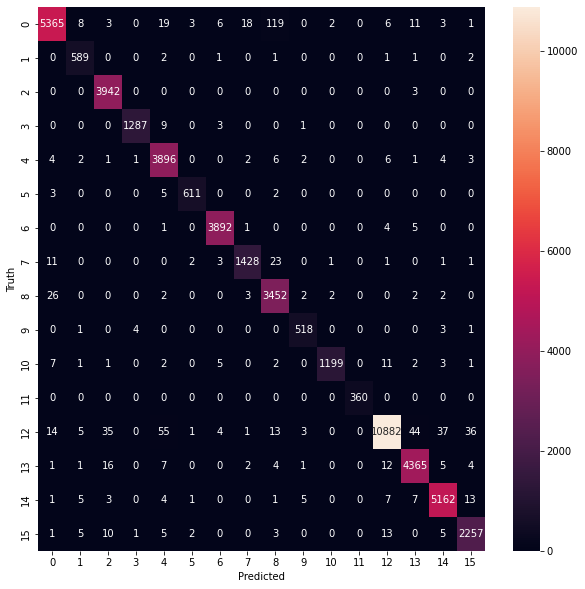

                              precision    recall  f1-score   support

            Backend Engineer       0.99      0.96      0.98      5564
             Cloud architect       0.95      0.99      0.97       597
            Customer Support       0.98      1.00      0.99      3945
                Data Analyst       1.00      0.99      0.99      1300
                Data Science       0.97      0.99      0.98      3928
     Database Administration       0.99      0.98      0.98       621
                      Design       0.99      1.00      1.00      3903
          Front End Engineer       0.98      0.97      0.98      1471
         Full Stack Engineer       0.95      0.99      0.97      3491
        Information Security       0.97      0.98      0.98       527
Mobile Application Developer       1.00      0.97      0.98      1234
      Network Administration       1.00      1.00      1.00       360
                      Non-IT       0.99      0.98      0.99     11130
          Product M

In [9]:
mod.confusion_matrix(z_train_tfidf, train['Type'])
mod.classification_report(z_train_tfidf, train['Type'])

In [10]:
mod.cross_evaluation(z_train_tfidf, train['Type'], cv_int=5)

Not Overfitting , mean_train_score: 0.986 , mean_test_score: 0.967


In [11]:
test['Type'] = mod.make_prediction(z_test_tfidf)
test.to_excel('x0pa_ds_interview_round_2_test.xlsx',index=False)

In [12]:
mod.save_model('sgd_classifier.pkl')

In [17]:
#from sqlalchemy import create_engine
#engine = create_engine('sqlite:///pynlp.db', echo=False)
#engine.execute('drop table Jobs')